In [3]:

import numpy as np
import xarray as xr


In [22]:
mooring_ds = xr.open_dataset('../rapid-geostrophic-reconstruction/data/mooring_data.nc')

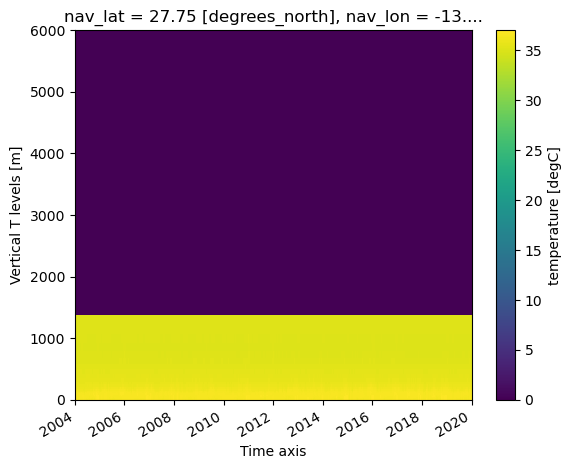

In [18]:
mooring_ds.sel(moorings = 'EBH3', variable = 'salt').votemper.plot(x = 'time_counter', y = 'deptht')

In [15]:
mooring_ds.moorings

<xarray.DataArray 'moorings' (moorings: 12)>
array(['_', 'WB3', '_', 'MAR12', 'MAR3', 'EBH4', 'EBH3', 'EBH2', 'EBH1', 'WB2',
       'WBH2', 'EB1'], dtype=object)
Coordinates:
    nav_lat   (moorings) float32 ...
    nav_lon   (moorings) float32 ...
    x         (moorings) int64 ...
    y         (moorings) int64 ...
  * moorings  (moorings) object '_' 'WB3' '_' 'MAR12' ... 'WB2' 'WBH2' 'EB1'

In [23]:
new_mooring_names = mooring_ds.moorings.values
new_mooring_names[0] = 'merged_west'
new_mooring_names[2] = 'merged_east'

mooring_ds = mooring_ds.assign_coords(moorings = new_mooring_names)

In [54]:
mooring_ds.sel(moorings = eastern_mooring_names).isel( time_counter = 0, variable = 0).votemper != 0

<xarray.DataArray 'votemper' (deptht: 46, moorings: 5)>
array([[ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
       [ True,  True,  True,  True,  True],
...
       [False, False,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False,  True,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False,  True,  True],
       [False, False, False, False,  True],
       [False, False, False, False,  True],
       [False, False, False, False,  True],
       [False, False, False, False,  True],
       [False, False, False, False,  True],
       [False, False, False, False,  True],
       [False, False, False, False,  True],
       [False, False, False, False,  True],
       [False, False, False, False, False],
       [False, False, False, False, False],
       [False, False, False, False, False]])
Coordinates:
  * deptht         (deptht) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
    nav_lat        (moorings) float32 ...
    nav_lon        (moorings) float32 ...
    time_centered  datetime64[ns] ...
    time_counter   datetime64[ns] 2004-01-01T12:00:00
    x              (moorings) int64 ...
    y              (moorings) int64 ...
    variable       <U4 'temp'
  * moorings       (moorings) object 'EBH4' 'EBH3' 'EBH2' 'EBH1' 'EB1'

In [34]:
def mooring_groups(moorings_list):

    """
        mooring_list: sorted from interior ocean to boundary
    """
    moorings_selector = xr.DataArray(moorings_list, dims = 'moorings', coords = {'i_moorings': (('moorings',),np.arange(len(moorings_list)))})

    mooring_subset = mooring_ds.sel(moorings = moorings_selector)

    valid_values_mask = mooring_subset.isel( time_counter = 0, variable = 0, drop = True).votemper != 0

    depth_mooring_i = mooring_subset.i_moorings.where(valid_values_mask).max('moorings').fillna(0).astype(int)


    mooring_group_merged = mooring_subset.isel(moorings = depth_mooring_i)
    return mooring_group_merged

western_mooring = mooring_groups(['WB3', 'WBH2', 'WB2']).votemper.rename('western_mooring')
eastern_mooring = mooring_groups(['EB1', 'EBH1', 'EBH2', 'EBH3','EBH4']).votemper.rename('eastern_mooring')
western_ridge_mooring = mooring_groups(['MAR12']).votemper.rename('western_ridge_mooring')
eastern_ridge_mooring = mooring_groups(['MAR3']).votemper.rename('eastern_ridge_mooring')

In [41]:

xr.concat([western_mooring, eastern_mooring, western_ridge_mooring, eastern_ridge_mooring], dim = 'mooring').assign_coords(mooring = ['western_mooring', 'eastern_mooring', 'western_ridge_mooring', 'eastern_ridge_mooring']).to_netcdf('../rapid-geostrophic-reconstruction/data/mooring_groups.nc')

In [43]:
tg_west = western_mooring.sel(variable = 'temp').rename('TG_west')
sg_west = western_mooring.sel(variable = 'salt').rename('SG_west')

tg_east = eastern_mooring.sel(variable = 'temp').rename('TG_east')
sg_east = eastern_mooring.sel(variable = 'salt').rename('SG_east')

tg_marwest = western_ridge_mooring.sel(variable = 'temp').rename('TG_marwest')
sg_marwest = western_ridge_mooring.sel(variable = 'salt').rename('SG_marwest')

tg_mareast = eastern_ridge_mooring.sel(variable = 'temp').rename('TG_mareast')
sg_mareast = eastern_ridge_mooring.sel(variable = 'salt').rename('SG_mareast')


In [45]:
xr.Dataset({'TG_west': tg_west, 'SG_west': sg_west, 'TG_east': tg_east, 'SG_east': sg_east, 'TG_marwest': tg_marwest, 'SG_marwest': sg_marwest, 'TG_mareast': tg_mareast, 'SG_mareast': sg_mareast})

MergeError: conflicting values for variable 'nav_lat' on objects to be combined. You can skip this check by specifying compat='override'.

In [46]:
tg_west.drop(['nav_lat','nav_lon', 'x', 'y', 'variable', 'moorings', 'i_moorings'])

<xarray.DataArray 'TG_west' (time_counter: 5844, deptht: 46)>
[268824 values with dtype=float32]
Coordinates:
  * deptht         (deptht) float32 3.047 9.454 16.36 ... 5.625e+03 5.875e+03
    nav_lat        (deptht) float32 ...
    nav_lon        (deptht) float32 ...
    time_centered  (time_counter) datetime64[ns] ...
  * time_counter   (time_counter) datetime64[ns] 2004-01-01T12:00:00 ... 2019...
    x              (deptht) int64 ...
    y              (deptht) int64 ...
    variable       <U4 'temp'
    moorings       (deptht) object 'WB2' 'WB2' 'WB2' 'WB2' ... 'WB3' 'WB3' 'WB3'
    i_moorings     (deptht) int64 2 2 2 2 2 2 2 2 2 2 2 ... 2 2 1 1 1 0 0 0 0 0
Attributes:
    standard_name:       sea_water_potential_temperature
    long_name:           temperature
    units:               degC
    online_operation:    average
    interval_operation:  300 s
    interval_write:      1 d
    cell_methods:        time: mean (interval: 300 s) time_counter: mean